Используя библиотеку LangChain и модель GigaChat, разработайте систему
автоматического извлечения общего количества проживающих из текстовых заявок на аренду жилья.

Данные:

• rental_applications_text.csv с полями

• text_id – уникальный идентификатор
• text – текст заявки

• rental_applications_amount.csv с полями

• amount – размеченное общее количество проживающих
• text_id – уникальный идентификатор
• text – текст заявки

Основная задача (обязательно всем):
1. Для каждой строки из rental_applications_text.csv извлечь значение total_persons (число проживающих) и сравнить с разметкой из rental_applications_amount.csv.

Дополнительный вариант:

извлечение count
_
adults (число взрослых) и count
_
children (число детей)

In [139]:
!pip install -q langchain langchain-gigachat pydantic pandas

In [140]:
import os
from typing import Optional

import pandas as pd
import matplotlib.pyplot as plt
from pydantic import BaseModel, Field
from typing import Optional
from tqdm.auto import tqdm


from langchain_gigachat.chat_models import GigaChat
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
GIGACHAT_API_KEY = ""

In [142]:
llm = GigaChat(
    credentials=GIGACHAT_API_KEY,
    model="GigaChat-2",
    verify_ssl_certs=False,
    temperature=0.0,
)

### Загрузка данных

In [143]:
df_text = pd.read_csv(
    "rental_applications_text.csv", # Тексты заявок
    sep=";",
    engine="python"
)

In [148]:
df_amount = pd.read_csv("rental_applications_amount.csv") # Разметка с количеством людей

In [149]:
print("df_text shape:", df_text.shape)
print("df_amount shape:", df_amount.shape)

df_text shape: (100, 2)
df_amount shape: (100, 3)


In [150]:
df_text.head()

,text_id,text
0,14205200,Сниму жилье. 500-600 рублей сутки. Эконом клас...
1,319097075,ищем жилье в центре недалеко от моря с 23.07-0...
2,98881311,Ищем жилье на период с 18-28июля..на две семьи...
3,44587027,2 семьи по 3 человека (2 взрослых и ребенок) с...
4,352802829,Сниму недорогое жилье в лазаревском на 6 чел 3...


In [151]:
df_amount.head()

,amount,text_id,text
0,1,14205200,Сниму жилье. 500-600 рублей сутки. Эконом клас...
1,5,319097075,ищем жилье в центре недалеко от моря с 23.07-0...
2,7,98881311,Ищем жилье на период с 18-28июля..на две семьи...
3,6,44587027,2 семьи по 3 человека (2 взрослых и ребенок) с...
4,6,352802829,Сниму недорогое жилье в лазаревском на 6 чел 3...


In [152]:
print("df_text.info()")
print(df_text.info())

print("\ndf_amount.info()")
print(df_amount.info())

df_text.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text_id  100 non-null    int64 
 1   text     100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB
None

df_amount.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   amount   100 non-null    int64 
 1   text_id  100 non-null    int64 
 2   text     100 non-null    object
dtypes: int64(2), object(1)
memory usage: 2.5+ KB
None


In [153]:
print("Дубликаты text_id в df_text:", df_text["text_id"].duplicated().sum())
print("Дубликаты text_id в df_amount:", df_amount["text_id"].duplicated().sum())

Дубликаты text_id в df_text: 0
Дубликаты text_id в df_amount: 0


### Длина текстов

In [154]:
df_text["text_len"] = df_text["text"].astype(str).str.len()
print("\nСтатистика длины текстов:")
display(df_text["text_len"].describe())


Статистика длины текстов:


,text_len
count,100.000000
mean,112.040000
std,38.807455
min,50.000000
25%,81.500000
50%,103.000000
75%,140.250000
max,209.000000


### Гистограмма распределения amount

Описание распределения amount:
count    100.000000
mean       3.650000
std        1.955954
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       12.000000
Name: amount, dtype: float64


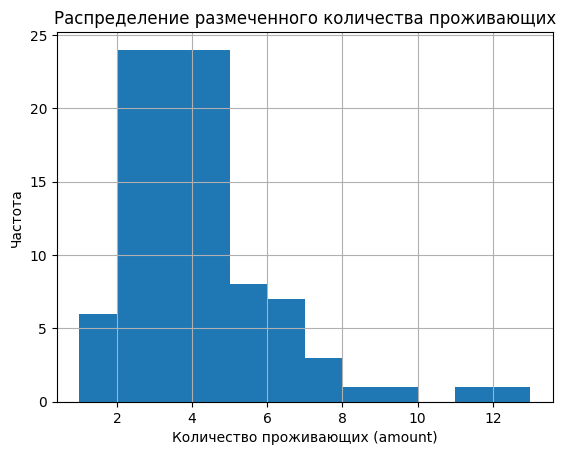

In [155]:
print("Описание распределения amount:")
print(df_amount["amount"].describe())

plt.figure()
df["amount"].hist(bins=range(int(df["amount"].min()), int(df["amount"].max()) + 2))
plt.xlabel("Количество проживающих (amount)")
plt.ylabel("Частота")
plt.title("Распределение размеченного количества проживающих")
plt.show()

### Описание структуры ответа

In [157]:
class RentalInfo(BaseModel):
    """
    Структура JSON-ответа при разборе заявки.
    Содержит количество людей, взрослых и детей.
    Если информации о взрослых/детях нет, считаем их количество равным 0.
    """
    total_persons: int = Field(
        description="Общее количество проживающих (взрослые + дети)."
    )
    count_adults: int = Field(
        description="Количество взрослых. Если в тексте нет информации — ставь 0."
    )
    count_children: int = Field(
        description="Количество детей. Если в тексте нет информации — ставь 0."
    )

#### Cтруктурированный вывод LLM

In [158]:
structured_llm = llm.with_structured_output(RentalInfo)

### ChatPromptTemplate

In [159]:
system_message = """
Ты эксперт по анализу русскоязычных текстовых заявок на аренду жилья.

По каждой заявке тебе нужно определить:
- total: сколько всего людей планирует проживать,
- count_adults: число взрослых,
- count_children: число детей.

Правила:

1. В total включай и взрослых, и детей.
2. Если в тексте явно написано, сколько взрослых и детей, используй эти числа.
3. Если указано только общее количество людей ("на 4 человек", "5 гостей"),
   то это и есть total, а count_adults и count_children можно оставить 0,
   если нельзя однозначно разделить.
4. Если встречаются диапазоны ("5-6 человек", "от 2 до 3 гостей"),
   выбери одно целое число, которое выглядит наиболее разумным.
5. Если количество людей не написано явно, но логично следует из текста
   ("я и жена", "мы с ребёнком", "семья с двумя детьми"), оцени его
   как можно аккуратнее.
6. Если совсем непонятно, осторожно оцени число людей, не занижая его.

Отвечай строго в формате JSON, соответствующем заданной схеме Pydantic-модели RentalInfo.
Не добавляй никаких пояснений, комментариев и текста вне JSON.
"""

human_message = """ Текст заявки: {text} """

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_message.strip()),
        ("human", human_message.strip()),
    ]
)

In [160]:
chain = prompt | structured_llm # prompt -> structured LLM

### Пример работы

In [161]:
test_texts = [
    "Снимем квартиру на семью из четырех человек",
    "Ищу студию на двоих взрослых",
    "Нужна квартира для семьи с двумя детьми",
]

for t in test_texts:
    result: RentalInfo = chain.invoke({"text": t})
    print("Текст:", t)
    print("Ответ модели:", result.model_dump())
    print("-" * 60)

Текст: Снимем квартиру на семью из четырех человек
Ответ модели: {'total_persons': 4, 'count_adults': 0, 'count_children': 0}
------------------------------------------------------------
Текст: Ищу студию на двоих взрослых
Ответ модели: {'total_persons': 2, 'count_adults': 2, 'count_children': 0}
------------------------------------------------------------
Текст: Нужна квартира для семьи с двумя детьми
Ответ модели: {'total_persons': 0, 'count_adults': 0, 'count_children': 2}
------------------------------------------------------------


### Словарь text_id -> amount

In [162]:
amount_by_id = (
    df_amount
    .set_index("text_id")["amount"]
    .to_dict()
)

### Функция для анализа одной заявки

In [163]:
def predict_rental_info(text: str) -> Optional[RentalInfo]:
    """
    Вызывает LLM-цепочку для одного текста и возвращает Pydantic-объект RentalInfo.
    В случае ошибки возвращает None.
    """
    try:
        result: RentalInfo = chain.invoke({"text": text})
        return result
    except Exception as exc:
        print(f"Ошибка при обработке текста: {exc}")
        return None

### Прогон по всему датасету

In [186]:
results = []

for row in tqdm(df_text.itertuples(index=False), total=len(df_text)):
    text_id = row.text_id
    text = row.text

    true_amount = amount_by_id.get(text_id, None)

    result = predict_rental_info(text)

    if result is None:
        pred_total = None
        pred_adults = None
        pred_children = None
    else:
        pred_total = result.total_persons
        pred_adults = result.count_adults
        pred_children = result.count_children

    results.append(
        {
            "text_id": text_id,
            "predicted_total_persons": pred_total,
            "true_total_persons": true_amount,
            "predicted_count_adults": pred_adults,
            "predicted_count_children": pred_children,
        }
    )

results_df = pd.DataFrame(results)
display(results_df.head(10))

  0%|          | 0/100 [00:00<?, ?it/s]

,text_id,predicted_total_persons,true_total_persons,predicted_count_adults,predicted_count_children
0,14205200,1,1,1,0
1,319097075,5,5,0,0
2,98881311,7,7,4,3
3,44587027,6,6,4,2
4,352802829,6,6,3,3
5,52157605,2,2,2,0
6,408430986,2,2,2,0
7,176294447,4,4,2,2
8,150296790,4,4,3,1
9,120627580,3,3,1,2


### Accuracy

In [187]:
results_df["correct"] = ( # Флаг корректности по total_persons
    results_df["predicted_total_persons"] == results_df["true_total_persons"]
)

In [188]:
accuracy = results_df["correct"].mean()
print(f"Accuracy по total: {accuracy:.3f}")

Accuracy по total: 0.980


In [189]:
results_df.to_csv("results.csv", index=False)

### Оценка размеченных самостоятельно данных

In [190]:
external = pd.read_csv("external.csv")

external.head()

,text_id,text,count_adults,count_children,count
0,71882262,"Интересует жильё-эконом, кондиционер только чт...",1,0,1
1,214627751,Здравствуйте! Интересует жилье недорого 1-10 с...,2,2,4
2,79737918,Добрый день!Ищем жилье с 25.04-05.05 2 взрослы...,2,1,3
3,245617104,Приезжаем 3 июля в Москву. Семейная пара. Ищем...,2,0,2
4,204925103,Ищем жилье на начало августа в Питере. Двое вз...,2,4,6


In [191]:
results_ext = []

for row in tqdm(external.itertuples(index=False), total=len(external)):
    text_id = row.text_id
    text = row.text

    true_total = row.count
    true_adults = row.count_adults
    true_children = row.count_children

    result = predict_rental_info(text)

    if result is None:
        pred_total = None
        pred_adults = None
        pred_children = None
    else:
        pred_total = result.total_persons
        pred_adults = result.count_adults
        pred_children = result.count_children

    results_ext.append(
        {
            "text_id": text_id,
            "text": text,
            "pred_total_persons": pred_total,
            "true_total_persons": true_total,
            "pred_count_adults": pred_adults,
            "true_count_adults": true_adults,
            "pred_count_children": pred_children,
            "true_count_children": true_children,
            "correct": (pred_total == true_total) if pred_total is not None else None,
        }
    )

  0%|          | 0/15 [00:00<?, ?it/s]

### Формируем DataFrame с результатами

In [192]:
results_ext_df = pd.DataFrame(results_ext)
results_ext_df

,text_id,text,pred_total_persons,true_total_persons,pred_count_adults,true_count_adults,pred_count_children,true_count_children,correct
0,71882262,"Интересует жильё-эконом, кондиционер только чт...",1,1,1,1,0,0,True
1,214627751,Здравствуйте! Интересует жилье недорого 1-10 с...,4,4,2,2,2,2,True
2,79737918,Добрый день!Ищем жилье с 25.04-05.05 2 взрослы...,3,3,2,2,1,1,True
3,245617104,Приезжаем 3 июля в Москву. Семейная пара. Ищем...,2,2,2,2,0,0,True
4,204925103,Ищем жилье на начало августа в Питере. Двое вз...,6,6,2,2,4,4,True
5,143782331,Здравствуйте. Интересует жилье 3 местный номер...,3,3,2,2,1,1,True
6,98770155,"Снимем жильё с 1.09по 8.09 двухместный,олимпий...",2,2,2,2,0,0,True
7,414557480,Ищем жильё с 4.07.на 20 дней. 2 взрослых и 2 д...,4,4,2,2,2,2,True
8,447606306,Добрый день! Ищем жильё (гостевой дом) с парко...,4,4,2,2,2,2,True
9,14205200,Сниму жилье. 500-600 рублей сутки. Эконом клас...,1,1,1,1,0,1,True


### Accuracy

In [193]:
results_ext_df["correct_total"] = results_ext_df["pred_total_persons"] == results_ext_df["true_total_persons"]
results_ext_df["correct_adults"] = results_ext_df["pred_count_adults"] == results_ext_df["true_count_adults"]
results_ext_df["correct_children"] = results_ext_df["pred_count_children"] == results_ext_df["true_count_children"]

In [194]:
# correct_all — True, если все три поля совпали
results_ext_df["correct_all"] = (
    results_ext_df["correct_total"]
    & results_ext_df["correct_adults"]
    & results_ext_df["correct_children"]
)

In [195]:
accuracy_total = results_ext_df["correct_total"].mean()
accuracy_adults = results_ext_df["correct_adults"].mean()
accuracy_children = results_ext_df["correct_children"].mean()
accuracy_all = results_ext_df["correct_all"].mean()

In [196]:
print(f"Accuracy total_persons:  {accuracy_total:.3f}")
print(f"Accuracy count_adults:   {accuracy_adults:.3f}")
print(f"Accuracy count_children: {accuracy_children:.3f}")
print(f"Accuracy all_fields:     {accuracy_all:.3f}")

Accuracy total_persons:  1.000
Accuracy count_adults:   0.933
Accuracy count_children: 0.933
Accuracy all_fields:     0.867


In [197]:
results_ext_df

,text_id,text,pred_total_persons,true_total_persons,pred_count_adults,true_count_adults,pred_count_children,true_count_children,correct,correct_total,correct_adults,correct_children,correct_all
0,71882262,"Интересует жильё-эконом, кондиционер только чт...",1,1,1,1,0,0,True,True,True,True,True
1,214627751,Здравствуйте! Интересует жилье недорого 1-10 с...,4,4,2,2,2,2,True,True,True,True,True
2,79737918,Добрый день!Ищем жилье с 25.04-05.05 2 взрослы...,3,3,2,2,1,1,True,True,True,True,True
3,245617104,Приезжаем 3 июля в Москву. Семейная пара. Ищем...,2,2,2,2,0,0,True,True,True,True,True
4,204925103,Ищем жилье на начало августа в Питере. Двое вз...,6,6,2,2,4,4,True,True,True,True,True
5,143782331,Здравствуйте. Интересует жилье 3 местный номер...,3,3,2,2,1,1,True,True,True,True,True
6,98770155,"Снимем жильё с 1.09по 8.09 двухместный,олимпий...",2,2,2,2,0,0,True,True,True,True,True
7,414557480,Ищем жильё с 4.07.на 20 дней. 2 взрослых и 2 д...,4,4,2,2,2,2,True,True,True,True,True
8,447606306,Добрый день! Ищем жильё (гостевой дом) с парко...,4,4,2,2,2,2,True,True,True,True,True
9,14205200,Сниму жилье. 500-600 рублей сутки. Эконом клас...,1,1,1,1,0,1,True,True,True,False,False
